# TP2 Apprentissage semi-supervisé
### ANTOINE Maxime, DUCRUET Thibault

Imports

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
from scipy.stats import mode
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

warnings.filterwarnings('ignore')

## Données
Charger les données

In [2]:
# Chargement du fichier
def chargement_fichier(f):
    # Lecture du fichier avec pandas du dossier data
    data = pd.read_csv("data/" + f, sep=r"\s+", engine="python", header=None)

    # Séparation des variables
    X = data.iloc[:, :-1].values.astype(float)  # récupère les  colonnes de données
    y = data.iloc[:, -1].values               # dernière colonne (cible)

    print("X shape :", X.shape)
    print("y shape :", y.shape)
    return X, y


Découpage des données en apprentissage et test

In [3]:
def decoupage_donnees(X, y):
    # Découpage stratifié
    X_A, X_T, y_A, y_T = train_test_split(
        X, y,
        test_size=1/2,
        stratify=y,
        random_state=42
    )

    print("Taille apprentissage :", X_A.shape)
    print("Taille test :", X_T.shape)
    return X_A, X_T, y_A, y_T


In [4]:
def rendre_semi_supervise(y_A, pourcentage_labellise):
    y_semi = y_A.copy()

    n_total = len(y_A)
    n_labellise = int((pourcentage_labellise / 100) * n_total)

    # Indices mélangés
    indices = np.random.permutation(n_total)

    # Indices à masquer
    indices_non_labellises = indices[n_labellise:]

    # Convention classique en semi-supervisé
    y_semi[indices_non_labellises] = -1  

    return y_semi


In [ ]:
X, y = chargement_fichier("Wave.txt")

X_A, X_T, y_A, y_T = decoupage_donnees(X, y)

y_A_semi = rendre_semi_supervise(y_A, 30)

X_l = X_A[y_A_semi != -1]
y_l = y_A_semi[y_A_semi != -1]

X_u = X_A[y_A_semi == -1]




X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (2500, 40)
Taille test : (2500, 40)
Labels connus : 750
Labels inconnus : 1750


In [6]:
import numpy as np

def score_fisher(X_l, y_l):
    n_features = X_l.shape[1]
    classes = np.unique(y_l)
    S1 = np.zeros(n_features)

    for v in range(n_features):
        mu = np.mean(X_l[:, v])

        num = 0.0
        den = 0.0

        for c in classes:
            X_c = X_l[y_l == c, v]
            n_c = len(X_c)
            mu_c = np.mean(X_c)
            var_c = np.var(X_c)

            num += n_c * (mu_c - mu) ** 2
            den += n_c * var_c

        S1[v] = num / den if den != 0 else 0

    return S1

S_fisher = score_fisher(X_l, y_l)
print("Scores Fisher :", S_fisher)

Scores Fisher : [0.00725156 0.06003144 0.20846389 0.27379355 0.46197138 0.59495165
 0.58993788 0.55116287 0.45448475 0.38194389 0.45462703 0.34493548
 0.42319073 0.46167501 0.59374388 0.54818817 0.50849318 0.3855146
 0.18003987 0.04013318 0.00223158 0.00217298 0.00173809 0.00442239
 0.00617668 0.00113593 0.00080089 0.00017897 0.00119769 0.00187536
 0.00009083 0.00318931 0.00033214 0.0049397  0.00586719 0.00008996
 0.00037675 0.0058057  0.00093905 0.00046072]


In [7]:
import numpy as np

def score_laplacien(X_u, t=10):
    n_samples, n_features = X_u.shape

    # ||x_i||^2 pour tous les i
    norms = np.sum(X_u ** 2, axis=1)

    # Matrice des distances euclidiennes au carré
    distances = norms[:, None] + norms[None, :] - 2 * X_u @ X_u.T

    # Matrice de similarité S
    S = np.exp(-distances / t)

    # Calcul de S2(v)
    S2 = np.zeros(n_features)

    for v in range(n_features):
        v_col = X_u[:, v]
        var_v = np.var(v_col)

        if var_v == 0:
            S2[v] = np.inf
            continue

        # (v_i - v_j)^2 sous forme vectorisée
        diff = v_col[:, None] - v_col[None, :]
        num = np.sum((diff ** 2) * S)

        S2[v] = num / var_v

    return S2

S2 = score_laplacien(X_u, t=10)
print("Scores Laplacien :", S2)

Scores Laplacien : [1157.76346733 1034.08084609  850.26792285  629.68569805  475.54276043
  417.54616046  340.01590002  413.32641023  485.17371567  597.66329364
  529.56127538  589.20280999  505.46818189  436.05119356  338.56402879
  415.08692337  487.73291728  608.33766813  844.01523876 1027.22876502
 1102.9437853  1138.21119286 1124.50799042 1113.1596416  1128.36648248
 1156.01831114 1103.04423355 1100.76388603 1122.37136996 1082.27740609
 1104.48618167 1161.43676372 1112.4549239  1127.99752423 1125.1775241
 1136.00712824 1146.92578223 1098.71143288 1107.9527739  1110.98245895]


In [8]:

def score_final(X_l, y_l, X_u):
    S1 = score_fisher(X_l, y_l)
    S2 = score_laplacien(X_u, t=10)

    score_final = S1 / S2
    return score_final

In [9]:
import numpy as np
import matplotlib.pyplot as plt

indices_tries = np.argsort(score_final(X_l, y_l, X_u))[::-1]

def plot_scores(score_final):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(score_final)), score_final)
    plt.xlabel("Indice de la variable")
    plt.ylabel("Score de pertinence")
    plt.title("Pertinence des variables")
    plt.show()


In [10]:
from sklearn.preprocessing import StandardScaler

X_A_l = X_A[y_A_semi != -1]
y_A_l = y_A_semi[y_A_semi != -1]

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def eval_mlp(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(50,),
                        max_iter=1000,
                        random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [12]:
def eval_variable_selection(X_A, y_A, X_T, y_T, indices):
    accs = []
    nb_vars = []
    for k in range(5, X_A.shape[1] + 1, 5):
        idx = indices[:k]
        acc = eval_mlp(X_A[:, idx], y_A,
                    X_T[:, idx], y_T)
        accs.append(acc)
        nb_vars.append(k)
    return accs, nb_vars

In [23]:
def plot_pourcenrage_unlabel(X_A_l, y_A_l, X_T, y_T, indices_tries):
    percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    accs_labels = []

    top20 = indices_tries[:20]

    for p in percentages:
        # Rendre A semi-supervisée
        y_A_semi_p = rendre_semi_supervise(y_A, p)

        # Garder uniquement les données labellisées
        mask = y_A_semi_p != -1
        X_A_l = X_A[mask][:, top20]
        y_A_l = y_A_semi_p[mask]

        # Normalisation
        scaler = StandardScaler()
        X_A_l = scaler.fit_transform(X_A_l)
        X_T_tmp = scaler.transform(X_T[:, top20])

        # Entraînement / test MLP
        acc = eval_mlp(X_A_l, y_A_l, X_T_tmp, y_T)
        accs_labels.append(acc)

    # Tracé de la courbe
    plt.figure()
    plt.plot(percentages, accs_labels, marker='o')
    plt.xlabel("% de données labellisées")
    plt.ylabel("Accuracy")
    plt.title("MLP – 20 variables vs % de données labellisées")
    plt.show()


In [24]:
def evaluation_selection(X_A_l, y_A_l, X_T, y_T, X_A_u):
    score_f = score_final(X_A_l, y_A_l, X_A_u)

    plot_scores(score_f)

    indices_tries = np.argsort(score_f)[::-1]   

    scaler = StandardScaler()
    X_A_l_scaled = scaler.fit_transform(X_A_l)
    X_T_scaled = scaler.transform(X_T)

    accs_norm, nb_vars_norm = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, indices_tries)

    accs_non_norm, nb_vars_non_norm = eval_variable_selection(X_A_l, y_A_l, X_T, y_T, indices_tries)

    accs_non_pert, nb_vars_non_pert = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, indices_tries[::-1])

    accs_sans_sel_norm, nb_vars_sans_sel_norm = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, np.arange(X_A_l.shape[1]))

    accs_sans_sel_non_norm, nb_vars_sans_sel_non_norm = eval_variable_selection(X_A_l, y_A_l, X_T, y_T, np.arange(X_A_l.shape[1]))

    # --- Plot sur une seule figure ---
    plt.figure(figsize=(10, 6))
    
    plt.plot(nb_vars_norm, accs_norm, marker='o', label='Variables pertinentes (normalisées)')
    plt.plot(nb_vars_non_norm, accs_non_norm, marker='s', label='Variables pertinentes (non normalisées)')
    plt.plot(nb_vars_non_pert, accs_non_pert, marker='^', label='Variables non pertinentes')
    plt.plot(nb_vars_sans_sel_norm, accs_sans_sel_norm, marker='d', label='Sans sélection (normalisées)')
    plt.plot(nb_vars_sans_sel_non_norm, accs_sans_sel_non_norm, marker='x', label='Sans sélection (non normalisées)')

    plt.xlabel("Nombre de variables")
    plt.ylabel("Accuracy")
    plt.title("Comparaison des performances MLP selon la sélection de variables")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_pourcenrage_unlabel(X_A_l, y_A_l, X_T, y_T, indices_tries)
    

In [25]:
def pipeline_evaluation():
    X, y = chargement_fichier("Wave.txt")
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y)
    y_A_semi = rendre_semi_supervise(y_A, 30)
    print("Labels connus :", np.sum(y_A_semi != -1))
    print("Labels inconnus :", np.sum(y_A_semi == -1))
    X_l = X_A[y_A_semi != -1]
    y_l = y_A_semi[y_A_semi != -1]
    X_u = X_A[y_A_semi == -1]
    evaluation_selection(X_l, y_l, X_T, y_T, X_u)

X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (2500, 40)
Taille test : (2500, 40)
Labels connus : 750
Labels inconnus : 1750


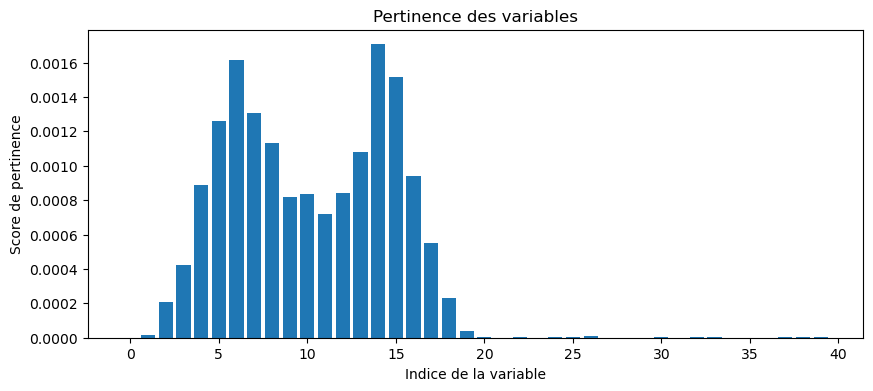

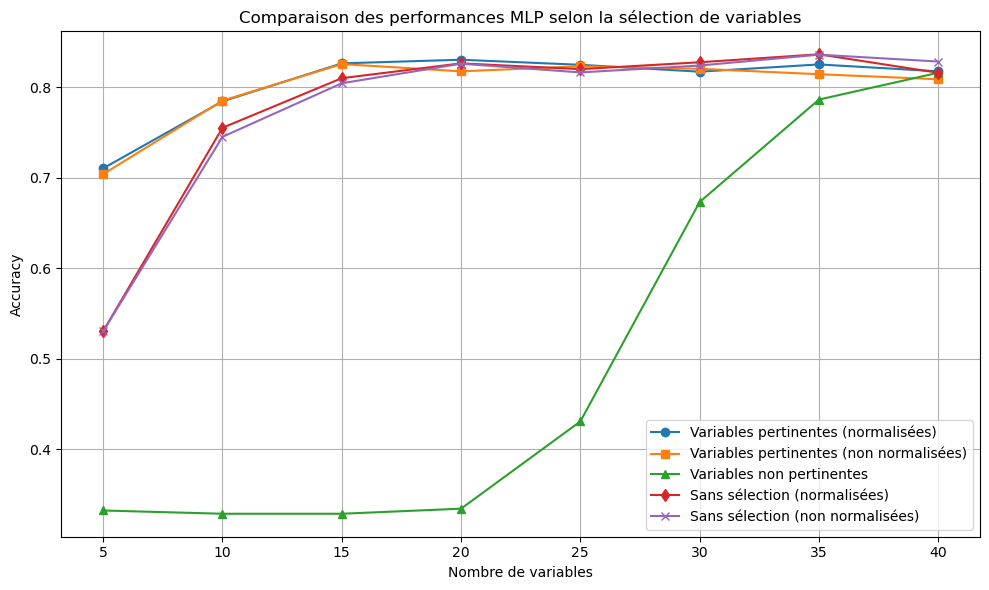

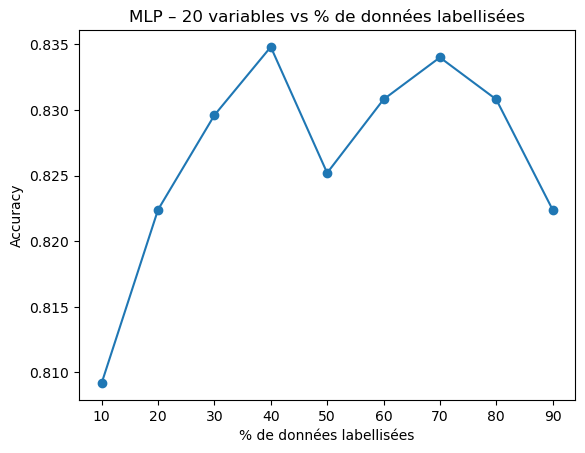

In [26]:
pipeline_evaluation()